# RISEI

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import datetime

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

# RANDOM_SEED = 250398
# tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.2
Num GPUs Available:  1


## Setup

In [4]:
%%time

ROOT_DIR = '../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False

class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path,
    ROOT_DIR,
    split=(0.8, 0.15, 0.05),
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq

model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../tmp\logs\20210505-214410
Wall time: 4 ms


In [5]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = 'ResNet18'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
    'l2_beta': 0.1,
#     'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 0.50,
#     'dropout': None,
    'output_bias': initial_bias,
    'batch_norm': True,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00005,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 175,
    'patience': 50,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0., 0.),
        'shear': (0.2, 0.5), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
#     'augmentations': False,
    'batch_size': 10,
#     'model_checkpoint_callback': False,
}

## Model

In [6]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 104, 128, 104)     0         
_________________________________________________________________
my_res_net (MyResNet)        (None, 512)               11770304  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [7]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, '20210310-204447', 'cp-0067.ckpt')

loading checkpoint from ../../../tmp\bckp-checkpoints\20210310-204447\cp-0067.ckpt...


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.8275862068965517
recall: 0.7741935483870968
f1-score: 0.7999999999999999
support: 62


CN
precision: 0.6666666666666666
recall: 0.7368421052631579
f1-score: 0.7
support: 38


micro avg
precision: 0.76
recall: 0.76
f1-score: 0.76
support: 100


macro avg
precision: 0.7471264367816092
recall: 0.7555178268251272
f1-score: 0.75
support: 100


weighted avg
precision: 0.7664367816091954
recall: 0.76
f1-score: 0.7619999999999999
support: 100


samples avg
precision: 0.76
recall: 0.76
f1-score: 0.76
support: 100


F1
micro: 0.76
macro: 0.75


accuracy_score: 0.76
sensitivity_score: 0.7741935483870968
specificity_score: 0.7368421052631579


Wall time: 24 s


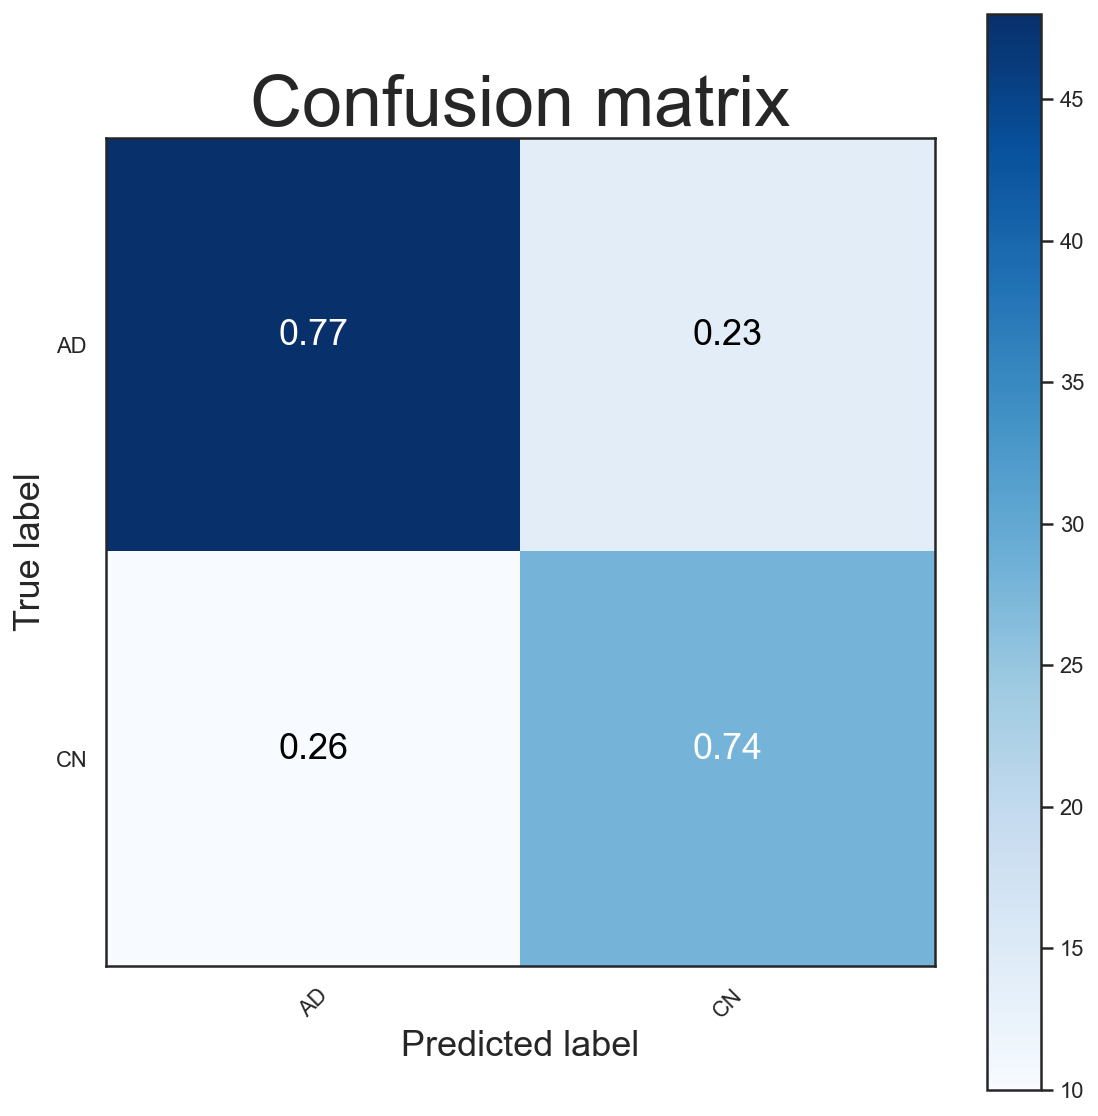

In [8]:
%%time

# just to test of it is ok to clear the session after loading the weigths
tf.keras.backend.clear_session()

show_metrics(model, test_seq, class_names)

## Experiments

In [9]:
import time

from src.heatmaps.evaluation import get_heatmap
from src.risei import RISEI
from src.data import tf_predict

In [10]:
from src.data import select_from_dataset, numpy_to_sequence

BATCH_SIZE = 24
images_x, images_y, images_y_pred = select_from_dataset(tf_predict(model), test_seq, max_category=10, fn_max=0, fp_max=0)
print(images_x.shape)
sequence = numpy_to_sequence(images_x, images_y, batch_size=BATCH_SIZE)

tp: 10, tn: 10, fp: 0, fn: 0
(20, 104, 128, 104, 1)


In [11]:
BATCH_SIZE = 24
VERBOSE = 1
LOG = True
SEED = 42
RISEI_BATCH_SIZE = 480

heatmap_evaluation_options = {
    'evaluation_step_size': 1000,
    'evaluation_max_steps': -1,
    'evaluation_batch_size': BATCH_SIZE
}

# risei config
risei_config = {
    's': 8, 
    'p1': 0.5, 
    'b1': 0, # will change
    'b2': 0, # will change
    'b2_value': 0, # will change
    'in_paint': '2d', 
    'in_paint_blending': True,
    'in_paint_radius': 5,
    'in_paint_2d_to_3d': True,
    'processes': 6,
}

In [12]:
import itertools

b2_value = [0, 1]
b2 = [0, 0.25, 0.5, 0.75, 1]
b1 = [0, 0.25, 0.5, 0.75, 1]

MASKS_COUNT = 1024
PATH = 'risei-2d-res-net-parameters'

def map_fn(config, options):
    config.update(options)
    return config

experiments = itertools.product(b1, b2, b2_value)
experiments = [{ 'b1': b1, 'b2': b2, 'b2_value': b2_value } for b1, b2, b2_value in experiments]
experiments = [(options, f"b1+{options['b1']}-b2+{options['b2']}-b2+{options['b2_value']}", map_fn(risei_config.copy(), { 'b1': options['b1'], 'b2': options['b2'], 'b2_value': options['b2_value'] })) 
               for options in experiments]

In [13]:
experiments[0]

({'b1': 0, 'b2': 0, 'b2_value': 0},
 'b1+0-b2+0-b2+0',
 {'s': 8,
  'p1': 0.5,
  'b1': 0,
  'b2': 0,
  'b2_value': 0,
  'in_paint': '2d',
  'in_paint_blending': True,
  'in_paint_radius': 5,
  'in_paint_2d_to_3d': True,
  'processes': 6})

In [14]:
from src.heatmaps.evaluation import HeatmapEvaluationV2
from src.heatmaps.heatmaps import get_heatmap
from src.data import tf_predict, torch_predict
from src.risei import RISEI


def get_heatmap_fn(risei, masks_count):
    def heatmap_fn(image_x, image_y, **kwargs): # kwargs - log, seed, evaluation_idx
        seed = kwargs.get('seed', None)
        evaluation_idx = kwargs.get('evaluation_idx', None)
        log = kwargs.get('log', None)
        heatmap_seed = None if seed is None else seed + evaluation_idx
        print(f"generating heatmap (masks_count={masks_count}; seed={heatmap_seed})")
        heatmap, _, _ = get_heatmap(
            image_x,
            image_y,
            model,
            risei,
            batch_size=BATCH_SIZE,
            masks_count=masks_count,
            risei_batch_size=RISEI_BATCH_SIZE,
            debug=False,
            seed=heatmap_seed,
            log=log
        )
        # print(f'{image_x.shape} {heatmap.shape}')
        return heatmap.reshape(input_shape)
    return heatmap_fn

predict_fn = tf_predict(model)

In [15]:
def run(experiments):
    for options, history_fname, risei_config in experiments:
        print(f'\n*********\nrunning experiment: {history_fname}\n---------\n')
        risei = RISEI(input_shape[:-1], debug=False, **risei_config)
        heatmap_fn = get_heatmap_fn(risei, MASKS_COUNT)
        he = HeatmapEvaluationV2(predict_fn, heatmap_fn, sequence, **heatmap_evaluation_options)
        
        for method in ['insertion', 'deletion']:
            print('\n')
            history = he.evaluate(method, log=LOG, verbose=VERBOSE, seed=SEED)
            history.save(os.path.join(ROOT_DIR, f'risei-history/{PATH}'), f'hmap-parameters--{method}--{history_fname}')
        
        tf.keras.backend.clear_session()

In [16]:
print(f'number of experiments: {len(experiments) * 2}')

number of experiments: 100


In [17]:
idx = 0
for i, e in enumerate(experiments):
    if e[0] == { 'b1': 0.5, 'b2': 0.5, 'b2_value': 0 }:
        idx = i
print(idx)
new_experiments = experiments[idx:]


def filter_fn(e):
    conf, *_ = e
    if conf['b2'] == 0 and conf['b2_value'] == 1:
        # don't do b2_value variations
        return False
    if conf['b1'] == 0.25 or conf['b1'] == 0.75:
        return False
    if conf['b2'] == 1 and conf['b1'] != 0:
        return False # allow only b2 = 1, b1 = 1
    # TODO: use later
    if conf['b2'] == 0.25 or conf['b2'] == 0.75:
        return False
    return True

new_experiments = list(filter(filter_fn, new_experiments))
len(new_experiments)

24


5

In [18]:
%%time

run(new_experiments[:5])


*********
running experiment: b1+0.5-b2+0.5-b2+0
---------



sequence len: 20, method: insertion
evaluation 1/20
generating heatmap...
generating heatmap (masks_count=1024; seed=42)
...finished in 0:12:29s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:34
auc: 1373148.8687992096 (0:13:03s)

evaluation 2/20
generating heatmap...
generating heatmap (masks_count=1024; seed=43)
...finished in 0:12:26s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:36
auc: 35726.002373260984 (0:13:02s)

evaluation 3/20
generating heatmap...
generating heatmap (masks_count=1024; seed=44)
...finished in 0:12:22s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:35
auc: 1349951.3340592384 (0:12:58s)

evaluation 4/20
generating heatmap...
generating heatmap (masks_count=1024; seed=45)
...finished in 0:12:32s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...f

...finished in 0:12:33s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:26
auc: 260635.63048653305 (0:13:00s)

evaluation 15/20
generating heatmap...
generating heatmap (masks_count=1024; seed=56)
...finished in 0:12:30s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:26
auc: 100144.07559603569 (0:12:57s)

evaluation 16/20
generating heatmap...
generating heatmap (masks_count=1024; seed=57)
...finished in 0:12:44s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:27
auc: 1382525.438606739 (0:13:11s)

evaluation 17/20
generating heatmap...
generating heatmap (masks_count=1024; seed=58)
...finished in 0:12:27s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:27
auc: 1377927.8925657272 (0:12:55s)

evaluation 18/20
generating heatmap...
generating heatmap (masks_count=1024; seed=59)
...finished in 0:12:29s
evaluate heatmaps

...finished in 0:12:31s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:27
auc: 244866.74591183328 (0:12:58s)

evaluation 8/20
generating heatmap...
generating heatmap (masks_count=1024; seed=49)
...finished in 0:12:37s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:27
auc: 208667.16173631983 (0:13:04s)

evaluation 9/20
generating heatmap...
generating heatmap (masks_count=1024; seed=50)
...finished in 0:12:35s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:27
auc: 1189824.0524977446 (0:13:02s)

evaluation 10/20
generating heatmap...
generating heatmap (masks_count=1024; seed=51)
...finished in 0:12:36s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:26
auc: 1365316.9049024582 (0:13:02s)

evaluation 11/20
generating heatmap...
generating heatmap (masks_count=1024; seed=52)
...finished in 0:12:50s
evaluate heatmaps 

...finished in 0:00:35
auc: 11548.296152072908 (0:13:02s)

saved to: ../../../tmp\risei-history/risei-2d-res-net-parameters\hmap-parameters--insertion--b1+1-b2+0-b2+0.cls


sequence len: 20, method: deletion
evaluation 1/20
generating heatmap...
generating heatmap (masks_count=1024; seed=42)
...finished in 0:12:24s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:25
auc: 1374209.169626236 (0:12:50s)

evaluation 2/20
generating heatmap...
generating heatmap (masks_count=1024; seed=43)
...finished in 0:12:19s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:27
auc: 164278.98296428064 (0:12:46s)

evaluation 3/20
generating heatmap...
generating heatmap (masks_count=1024; seed=44)
...finished in 0:12:13s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:27
auc: 1335316.7359232903 (0:12:40s)

evaluation 4/20
generating heatmap...
generating heatmap (masks_count=1024; 

...finished in 0:00:35
auc: 1252548.6147254705 (0:13:06s)

evaluation 14/20
generating heatmap...
generating heatmap (masks_count=1024; seed=55)
...finished in 0:12:31s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:35
auc: 48714.765630460075 (0:13:06s)

evaluation 15/20
generating heatmap...
generating heatmap (masks_count=1024; seed=56)
...finished in 0:12:27s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:35
auc: 53916.71393069878 (0:13:02s)

evaluation 16/20
generating heatmap...
generating heatmap (masks_count=1024; seed=57)
...finished in 0:12:35s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:36
auc: 1379438.8654828072 (0:13:11s)

evaluation 17/20
generating heatmap...
generating heatmap (masks_count=1024; seed=58)
...finished in 0:12:22s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:35
auc: 1280808.43245

...finished in 0:00:35
auc: 1257486.6036474705 (0:13:05s)

evaluation 7/20
generating heatmap...
generating heatmap (masks_count=1024; seed=48)
...finished in 0:12:30s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:36
auc: 252007.84835700234 (0:13:06s)

evaluation 8/20
generating heatmap...
generating heatmap (masks_count=1024; seed=49)
...finished in 0:12:29s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:35
auc: 77555.19447645656 (0:13:05s)

evaluation 9/20
generating heatmap...
generating heatmap (masks_count=1024; seed=50)
...finished in 0:12:25s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:36
auc: 1370946.8585848808 (0:13:01s)

evaluation 10/20
generating heatmap...
generating heatmap (masks_count=1024; seed=51)
...finished in 0:12:46s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:35
auc: 1319192.96380877

...finished in 0:13:02s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:28
auc: 34927.23591110553 (0:13:30s)

saved to: ../../../tmp\risei-history/risei-2d-res-net-parameters\hmap-parameters--deletion--b1+1-b2+0.5-b2+1.cls
Wall time: 1d 19h 31min 50s


In [19]:
%%time

run(new_experiments[5:10])

Wall time: 0 ns


In [20]:
%%time

run(new_experiments[10:15])

Wall time: 0 ns


In [21]:
%%time

run(new_experiments[15:])

Wall time: 0 ns
